# Offline 2: Logistic Regression with Bagging and Stacking

### Imports

In [96]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, average_precision_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler

#pred flag
pred_flag = 0 #no pred columns in dataset

### Scaling Function 

In [97]:
def dataScaler(sl, dataframe):
    dataframe_scaled = dataframe.copy()
    if sl == 1:
        for col in dataframe.columns:
            if dataframe[col].dtype == 'int64':
                scaler = StandardScaler()
                dataframe_scaled[col] = scaler.fit_transform(dataframe[[col]])
    elif sl == 2:
        for col in dataframe.columns:
            if dataframe[col].dtype == 'int64':
                scaler = MinMaxScaler()
                dataframe_scaled[col] = scaler.fit_transform(dataframe[[col]])

    return dataframe_scaled

### Preprocessing Dataset1: Telco Customer Churn

In [129]:
def DS1():
    dataframe = pd.read_csv('WA_Fn-UseC_-Telco-Customer-Churn.csv')

    pd.set_option('display.max_columns', None)

    print("Number of missing values IN DS1:")
    dataframe.isnull().sum()

    print("Number of duplicated rows IN DS1:")
    print(dataframe.duplicated().sum())

    print("data types:")
    print(dataframe.dtypes)

    print("Number of unique values in TotalCharges column:")
    print(dataframe['TotalCharges'].value_counts())

    dataframe['TotalCharges'] = dataframe['TotalCharges'].replace(' ', None)

    print("Number of unique values in TotalCharges column after replacement:")
    print(dataframe['TotalCharges'].value_counts())

    print("Number of missing values IN DS1 after replacement:")
    dataframe.isnull().sum()

    dataframe['TotalCharges'] = dataframe['TotalCharges'].astype(float)
    dataframe.fillna(dataframe['TotalCharges'].mean(), inplace=True)

    print("Number of missing values after filling:")
    print(dataframe.isnull().sum())

    features = dataframe.drop(['customerID', 'Churn'], axis=1)
    target = dataframe['Churn']

    for col in features.columns:
        if features[col].dtype == 'object':
            features[col] = features[col].astype('category')

    features = pd.get_dummies(features)

    for col in features.columns:
        if features[col].dtype == 'bool':
            features[col] = features[col].astype('int64')

    print("data types after encoding and conversion:")
    print(features.dtypes.tolist())

    #convert target to numeric
    target = target.replace({'Yes': 1, 'No': 0})

    #scaling
    dataframe_scaled = dataScaler(1, features)

    # split the data
    X_train_and_validation, X_test, y_train_and_validation, y_test = train_test_split(dataframe_scaled, target, test_size=0.2, random_state=42)
    
    X_train, X_validation, y_train, y_validation = train_test_split(X_train_and_validation, y_train_and_validation, test_size=0.2, random_state=42)

    return X_train, X_validation, X_test, y_train, y_validation, y_test
    

### Preprocessing Dataset3: Credit Card Fraud Detection

In [98]:
def DS3():
    dataframe = pd.read_csv('creditcard.csv')

    pd.set_option('display.max_columns', None)

    print("Number of missing values IN DS3:")
    dataframe.isnull().sum()

    print("Number of duplicated rows IN DS3:")
    print(dataframe.duplicated().sum())

    #no missing values
    #dataframe.fillna(dataframe.mode, inplace=True) #for non-numerical values
    #dataframe.dropna(subset=['Class'], inplace=True)

    if dataframe.duplicated().sum() > 0:
        dataframe.drop_duplicates(inplace=True)

    features = dataframe.drop('Class', axis=1)
    target = dataframe['Class']

    #data scaling
    dataframe_scaled = dataScaler(1, features)

    # split the data
    X_train_and_validation, X_test, y_train_and_validation, y_test = train_test_split(dataframe_scaled, target, test_size=0.2, random_state=42)
    
    X_train, X_validation, y_train, y_validation = train_test_split(X_train_and_validation, y_train_and_validation, test_size=0.2, random_state=42)
    return X_train, X_validation, X_test, y_train, y_validation, y_test


### Bagging

In [99]:

def Bagging(X_train, y_train):
    rows = X_train.shape[0]

    sampleset = [] 
    targetset = [] 
    randset = []

    
    for i in range(9):
        randset.append(np.random.randint(0, rows, rows)) #indices
        sampleset.append(X_train.iloc[randset[i]])
        targetset.append(y_train.iloc[randset[i]])

    
    LR = []

    for i in range(9):
        clf = LogisticRegression(max_iter=100)
        clf.fit(sampleset[i], targetset[i])
        LR.append(clf)

    #print(randset)

    return LR



### Voting Ensemble

In [38]:
def Voting(X_test, y_test, LR):
    rows = X_test.shape[0]
    votingPredictor = []

    #reindex X_test
    X_test = X_test.reset_index(drop=True)
    y_test = y_test.reset_index(drop=True)

    for i in range(rows):
        voteCount = 0
        for j in range(9):
            prediction = LR[j].predict(X_test.iloc[[i]])
            if prediction == 0:
                voteCount += 1
        if voteCount >= 5:
            votingPredictor.append(0)
        else:
            votingPredictor.append(1)


    return votingPredictor    

### Stacking

In [101]:
def Stacking(X_validation, y_validation, LR):
    y_pred = []

    for i in range(9):
        y_pred.append(LR[i].predict(X_validation))
        
    for i in range(9):
        X_validation['pred' + str(i)] = y_pred[i]


    # #append the predictions to the validation set's features
    # X_validation['pred1'] = y_pred[0]
    # X_validation['pred2'] = y_pred[1]
    # X_validation['pred3'] = y_pred[2]
    # X_validation['pred4'] = y_pred[3]
    # X_validation['pred5'] = y_pred[4]
    # X_validation['pred6'] = y_pred[5]
    # X_validation['pred7'] = y_pred[6]
    # X_validation['pred8'] = y_pred[7]
    # X_validation['pred9'] = y_pred[8]

    #print(X_validation)

    metaLR = LogisticRegression(max_iter=100)
    metaLR.fit(X_validation, y_validation)

    return metaLR

### Stacking Ensemble

In [102]:
def testMetaClassifier(LR, metaLR, X_test):
    y_pred = []
    y_final_pred = []
    for i in range(9):
        y_pred = LR[i].predict(X_test)
    
    for i in range(9):
        X_test['pred' + str(i)] = y_pred[i]

    global pred_flag
    pred_flag = 1

    y_final_pred = metaLR.predict(X_test)

    return y_final_pred
        
    
    


### Performance Metrics

In [103]:
# def getConfusionMatrix(y_test, y_pred):
#     return confusion_matrix(y_test, y_pred)

def getScores(y_test, y_pred):
    accuracy = accuracy_score(y_test, y_pred)
    sensitivity = recall_score(y_test, y_pred)
    specificity = recall_score(y_test, y_pred, pos_label=0)
    precision = precision_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    auroc = roc_auc_score(y_test, y_pred)
    aupr = average_precision_score(y_test, y_pred)

    return accuracy, sensitivity, specificity, precision, f1, auroc, aupr

### Call data preprocessing

In [130]:
X_train, X_validation, X_test, y_train, y_validation, y_test = DS1()
#X_train, X_validation, X_test, y_train, y_validation, y_test = DS3()

Number of missing values IN DS1:
Number of duplicated rows IN DS1:
0
data types:
customerID           object
gender               object
SeniorCitizen         int64
Partner              object
Dependents           object
tenure                int64
PhoneService         object
MultipleLines        object
InternetService      object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
StreamingTV          object
StreamingMovies      object
Contract             object
PaperlessBilling     object
PaymentMethod        object
MonthlyCharges      float64
TotalCharges         object
Churn                object
dtype: object
Number of unique values in TotalCharges column:
TotalCharges
          11
20.2      11
19.75      9
20.05      8
19.9       8
          ..
6849.4     1
692.35     1
130.15     1
3211.9     1
6844.5     1
Name: count, Length: 6531, dtype: int64
Number of unique values in TotalCharges column after replacement:
TotalCh

### Call Bagging

In [131]:
LR = Bagging(X_train, y_train)

/home/neha/.local/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/neha/.local/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
 

### Majority Voting and Metrics

In [132]:
y_pred = Voting(X_test, y_test, LR)
# Xnumpy = X_test.to_numpy()
# ynumpy = y_test.to_numpy()

# print(Xnumpy)
# print(ynumpy)

In [134]:
#get scores
accuracy, sensitivity, specificity, precision, f1, auroc, aupr = getScores(y_test, y_pred)

print("Accuracy: ", accuracy)
print("Sensitivity: ", sensitivity)
print("Specificity: ", specificity)
print("Precision: ", precision)
print("F1: ", f1)
print("ROC: ", auroc)
print("AUPR: ", aupr)

# acc = accuracy_score(y_test, y_pred)

# print("Accuracy: ", acc)
# print(X_test.shape[0])
# print(y_test.shape[0])
# print(len(y_pred))

# print("test: ")
# print(y_test)

# print("pred: ")
# print(y_pred)

Accuracy:  0.8147622427253371
Sensitivity:  0.5924932975871313
Specificity:  0.8947876447876448
Precision:  0.6696969696969697
F1:  0.6287339971550497
ROC:  0.7436404711873881
AUPR:  0.5046688935680995


### Call Stacking

In [135]:
metaLR = Stacking(X_validation, y_validation, LR)

/home/neha/.local/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


### Stacking Ensemble Testing and Metrics

In [136]:
y_final_pred = testMetaClassifier(LR, metaLR, X_test)

accuracy, sensitivity, specificity, precision, f1, auroc, aupr = getScores(y_test, y_final_pred)

print("Accuracy: ", accuracy)
print("Sensitivity: ", sensitivity)
print("Specificity: ", specificity)
print("Precision: ", precision)
print("F1: ", f1)
print("ROC: ", auroc)
print("AUPR: ", aupr)

Accuracy:  0.7998580553584103
Sensitivity:  0.4477211796246649
Specificity:  0.9266409266409267
Precision:  0.6872427983539094
F1:  0.5422077922077922
ROC:  0.6871810531327958
AUPR:  0.4538961372050414


### Build Dataframe for Violin Plots

In [137]:
#Draw violin plots for each performance metric for the 9 bagging LR learners
# Create a dataframe for the 9 bagging LR learners and the metrics

metrics = pd.DataFrame(columns=['Sl', 'Accuracy', 'Sensitivity', 'Specificity', 'Precision', 'F1', 'AUROC', 'AUPR'])

#print(y_pred)

#remove pred0 to pred8 columns
if pred_flag == 1:
    X_test = X_test.drop(columns=['pred0', 'pred1', 'pred2', 'pred3', 'pred4', 'pred5', 'pred6', 'pred7', 'pred8'])
    pred_flag = 0


for i in range(9):
    y_new = LR[i].predict(X_test)
    accuracy, sensitivity, specificity, precision, f1, auroc, aupr = getScores(y_test, y_new)
    metrics.loc[i] = [i+1, accuracy, sensitivity, specificity, precision, f1, auroc, aupr]




#X_test


metrics

,Sl,Accuracy,Sensitivity,Specificity,Precision,F1,AUROC,AUPR
0,1.0,0.808375,0.603217,0.882239,0.648415,0.625000,0.742728,0.496174
1,2.0,0.818311,0.573727,0.906371,0.688103,0.625731,0.740049,0.507629
2,3.0,0.813343,0.568365,0.901544,0.675159,0.617176,0.734955,0.498002
3,4.0,0.812633,0.595174,0.890927,0.662687,0.627119,0.743050,0.501582
4,5.0,0.807665,0.568365,0.893822,0.658385,0.610072,0.731094,0.488468
5,6.0,0.812633,0.565684,0.901544,0.674121,0.615160,0.733614,0.496315
6,7.0,0.815472,0.584450,0.898649,0.674923,0.626437,0.741550,0.504466
7,8.0,0.807665,0.597855,0.883205,0.648256,0.622036,0.740530,0.494022
8,9.0,0.811923,0.579088,0.895753,0.666667,0.619799,0.737421,0.497486


### Violin Plots

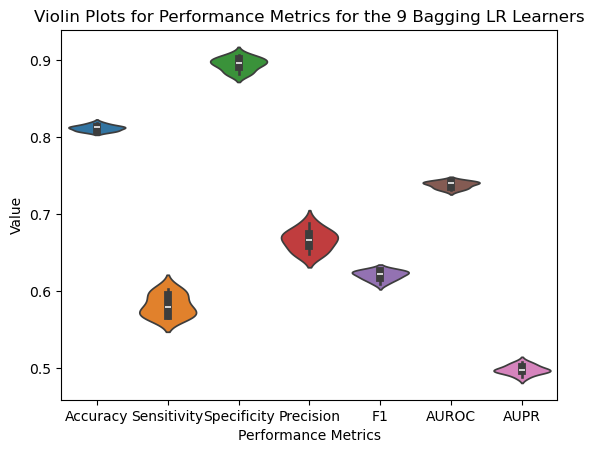

In [138]:
#violin plots from metrics except for Sl

import seaborn as sns
import matplotlib.pyplot as plt

sns.violinplot(data=metrics.iloc[:, 1:], gridsize=300)
plt.xlabel('Performance Metrics')
plt.ylabel('Value')
plt.title('Violin Plots for Performance Metrics for the 9 Bagging LR Learners')
plt.show()


In [120]:
metrics.describe()

,Sl,Accuracy,Sensitivity,Specificity,Precision,F1,AUROC,AUPR
count,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000
mean,5.000000,0.999009,0.595062,0.999651,0.734800,0.654903,0.797356,0.436548
std,2.738613,0.000058,0.053029,0.000091,0.047138,0.025515,0.026479,0.031137
min,1.000000,0.998943,0.511111,0.999594,0.697368,0.634483,0.755476,0.411325
25%,3.000000,0.998960,0.577778,0.999594,0.710526,0.638554,0.788704,0.412237
50%,5.000000,0.998996,0.588889,0.999612,0.719512,0.644737,0.794241,0.428250
75%,7.000000,0.999048,0.600000,0.999629,0.729412,0.654545,0.799815,0.432634
max,9.000000,0.999101,0.688889,0.999841,0.836364,0.708571,0.844241,0.502977
